In [1]:
%load_ext autoreload
%autoreload 2


import os
import time
import datetime
import calendar
import tqdm
import cftime

from glob import glob
from os.path import join

import dask

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm
import cartopy.crs as ccrs

from distributed import wait

%matplotlib inline

In [22]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='2:00:00', # Amount of wall time
        interface='ext', # Interface to use  'lo' provided a cluster window, below.
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [23]:
cluster, client = get_ClusterClient(nmem='1GB')
cluster.scale(10) 
cluster

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.1

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.95:35325,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [94]:
# -- read only these variables from the whole netcdf files
# average over time
def preprocess (ds):
    variables = ['GPP', 'TOTECOSYSC', 'TOTVEGC','ELAI','TOTSOMC',
                 'SOM_PAS_C_vr','SOM_SLO_C_vr','ALT']

    ds_new= ds[variables]
    return ds_new



In [95]:
case = 'ctsm51d159_f45_GSWP3_bgccrop_'
type = ['1850pAD','1850pSASU']
cases = [case+'1850pAD',case+'1850pSASU']
cases

['ctsm51d159_f45_GSWP3_bgccrop_1850pAD',
 'ctsm51d159_f45_GSWP3_bgccrop_1850pSASU']

In [96]:
for c in range(len(cases)):

    sim_files =[]
    sim_path = "/glade/derecho/scratch/slevis/archive/"+cases[c]+"/lnd/hist/"
    sim_files.extend(sorted(glob(join(sim_path+cases[c]+".clm2.h0.*.nc"))))
    # subset last 20 years of data 
    sim_files = sim_files[-240:None]
    print("All simulation files for "+cases[c]+": [", len(sim_files), "files]")

    temp = xr.open_mfdataset(sim_files, decode_times=True, combine='by_coords',
                             parallel=True,preprocess=preprocess).mean('time')
  
    if c == 0:
        ds = temp
    else:
        ds = xr.concat([ds, temp],'case')
        
ds = ds.assign_coords({"case": type})

# Calculate differences
diff = ds.isel(case=1)  - ds.isel(case=0) 
rel_diff = diff / ds.isel(case=1) 

All simulation files for ctsm51d159_f45_GSWP3_bgccrop_1850pAD: [ 240 files]
All simulation files for ctsm51d159_f45_GSWP3_bgccrop_1850pSASU: [ 240 files]


### Quickplots of pSASU results & difference from pAD

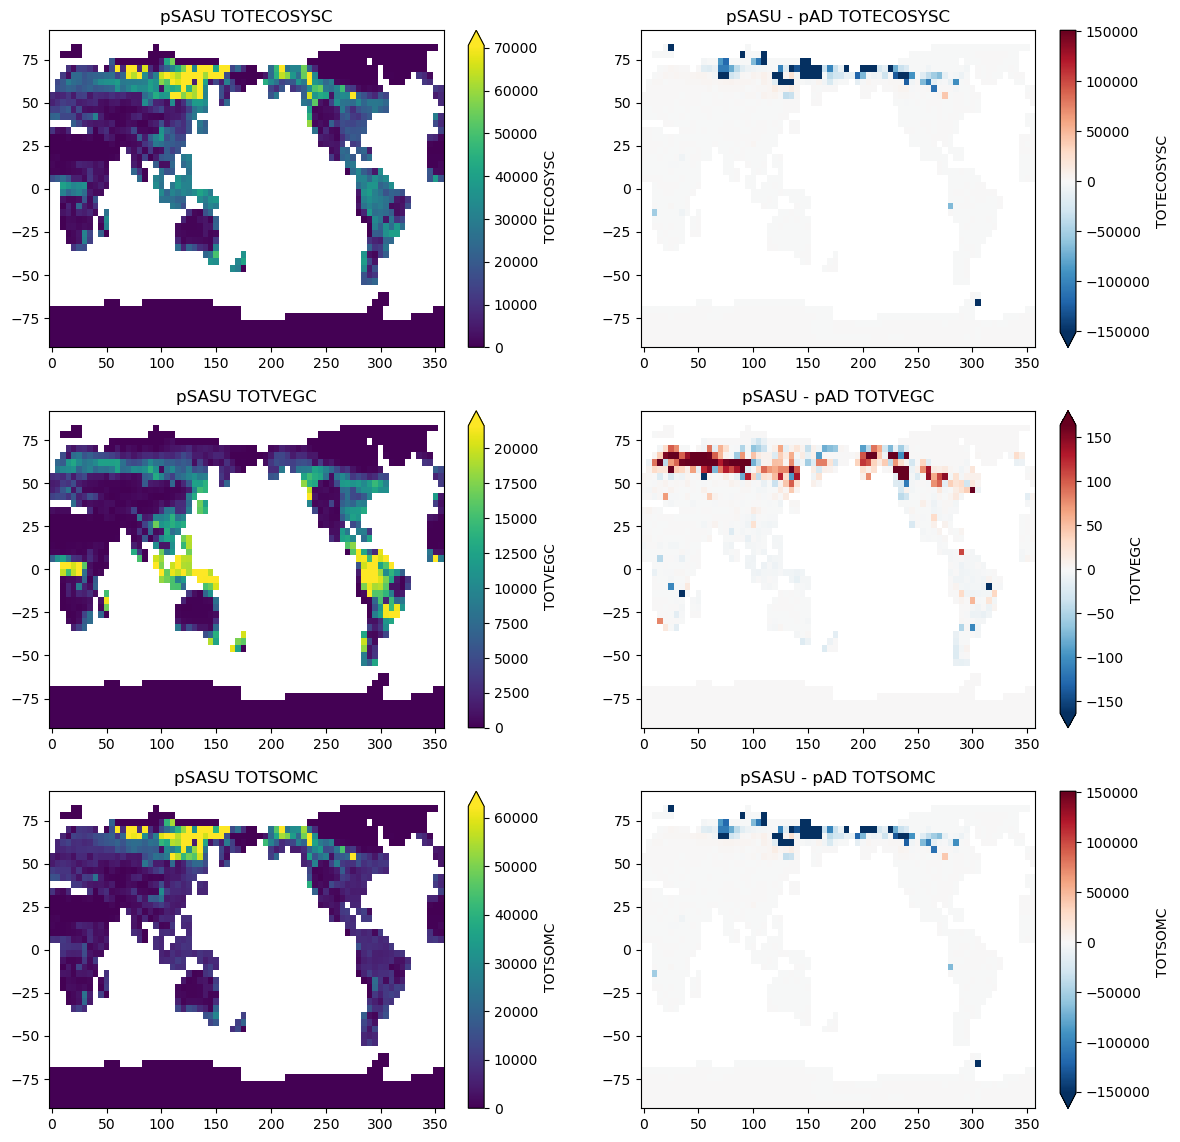

In [92]:
plt.figure(figsize=[14,14])
var = ['TOTECOSYSC' ,'TOTVEGC','TOTSOMC']
#var = ['GPP' ,'ELAI','ALT']
i = 1
for v in range(len(var)):
    plt.subplot(3, 2, i)
    ds[var[v]].isel(case=1).plot(robust=True)  
    plt.title("pSASU "+ var[v])
    plt.xlabel(None)
    plt.ylabel(None)
    i = i+1
    
    plt.subplot(3, 2, i)
    diff[var[v]].plot(robust=True) 
    plt.title("pSASU - pAD "+ var[v]) 
    plt.xlabel(None)
    plt.ylabel(None)   
    i = i+1


### lower soil C stocks at high latitues
- Look at depth profiles of pools for a few points

Text(0, 0.5, '')

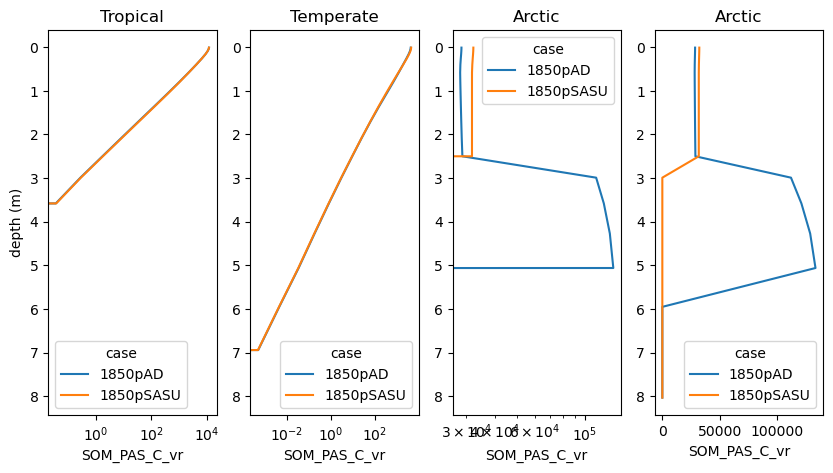

In [99]:
plt.figure(figsize=[10,5])
var = 'SOM_PAS_C_vr'
plt.subplot(1, 4, 1)
ds[var].sel(lon=300,lat=-10, method='nearest').plot(hue='case',y='levsoi') ;
plt.gca().invert_yaxis() ;
plt.title('Tropical')
plt.ylabel('depth (m)')
plt.xscale('log',base=10) 
#plt.ylim(6,0)


plt.subplot(1, 4, 2)
ds[var].sel(lon=25,lat=50, method='nearest').plot(hue='case',y='levsoi') ;
plt.gca().invert_yaxis() ;
plt.title('Temperate')
plt.ylabel(None)
plt.xscale('log',base=10) 
#plt.ylim(6,0)

plt.subplot(1, 4, 3)
ds[var].sel(lon=155,lat=66, method='nearest').plot(hue='case',y='levsoi') ;
plt.gca().invert_yaxis() ;
plt.title('Arctic')
plt.ylabel(None)
plt.xscale('log',base=10) 
#plt.ylim(6,0)


plt.subplot(1, 4, 4)
ds[var].sel(lon=155,lat=66, method='nearest').plot(hue='case',y='levsoi') ;
plt.gca().invert_yaxis() ;
plt.title('Arctic')
plt.ylabel(None)
#plt.ylim(6,0)

### Big blob of passive C with depth in pAD

In [24]:
ds['ASA'] = 100*(ds.FSR/ds.FSDS)
ds['ASA'].attrs['long_name'] = 'all sky albedo (%, FSR/FSDS)'

ds['SNOW_ALB'] = 100*((ds.SNOFSRVD + ds.SNOFSRVI + ds.SNOFSRND + ds.SNOFSRNI)/ds.FSDS).where(ds.SNOFSRVD>0)
ds['SNOW_ALB'].attrs['long_name'] = 'Snow Albedo'



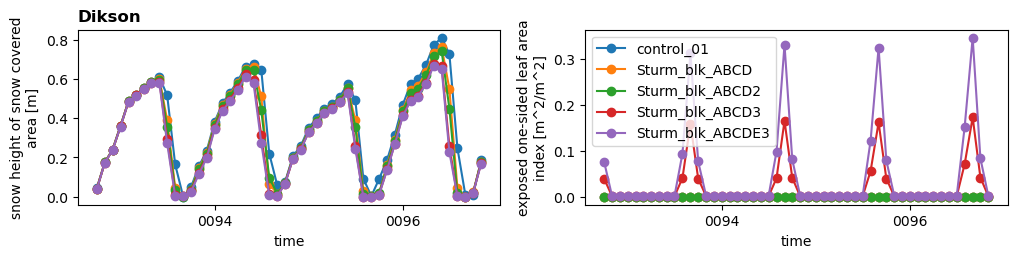

In [25]:
plt.figure(figsize=[12,5])
var = ['SNOW_DEPTH','ELAI']
for i in range(len(var)):
    plt.subplot(2, 2, (1+i))
    ds[var[i]].isel(time=slice(1100,1150)).plot.line(hue='sim',marker="o",add_legend=False)
    if i == 0:
        plt.title(site, loc='left', fontsize='large', fontweight='bold') 
    if i == 1:
        plt.legend(labels=exper)
    #if i == 2:
        #plt.hlines(273.15,90,100,color='k',lw=2,linestyles='dashed')


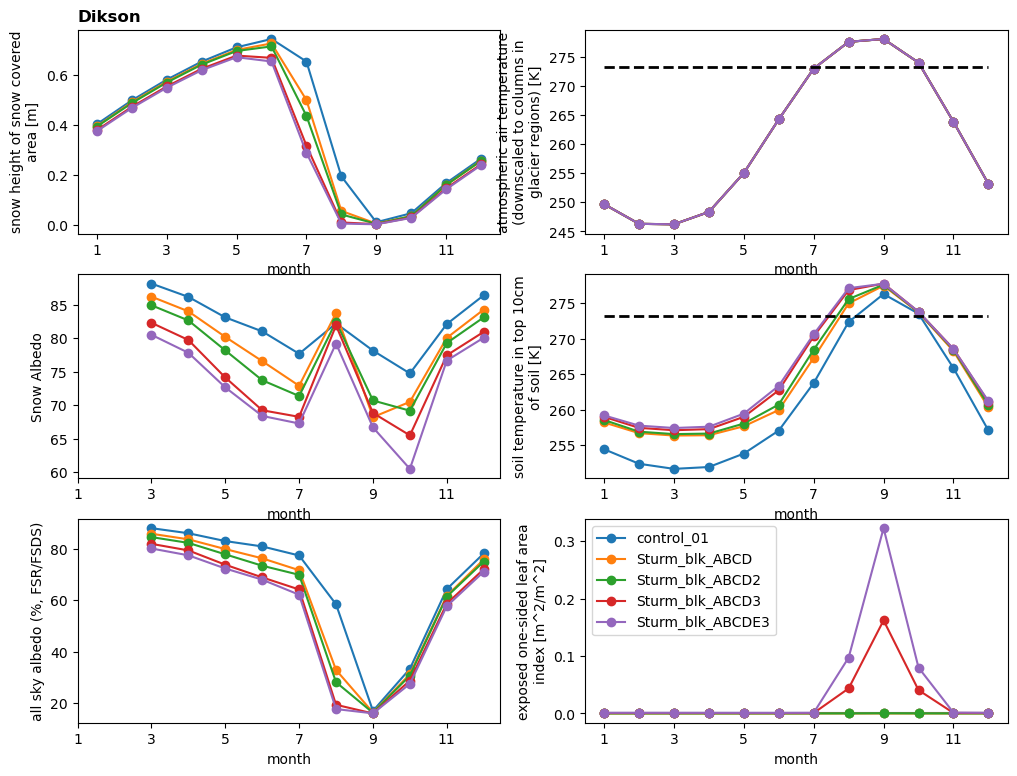

In [29]:
plt.figure(figsize=[12,9])
var = ['SNOW_DEPTH','TBOT','SNOW_ALB','TSOI_10CM','ASA','ELAI']
dt = ds.isel(time=slice(-120,None)).groupby('time.month').mean()
for i in range(len(var)):
    plt.subplot(3, 2, (1+i))
    dt[var[i]].plot.line(hue='sim',marker="o",add_legend=False)
    plt.xticks(ticks=[1,3,5,7,9,11])
    if i == 0:
        plt.title(site, loc='left', fontsize='large', fontweight='bold') 
    if i == 5:
        plt.legend(labels=exper)
    if i == 1:
        plt.hlines(273.15,1,12,color='k',lw=2,linestyles='dashed')
    if i == 3:
        plt.hlines(273.15,1,12,color='k',lw=2,linestyles='dashed')


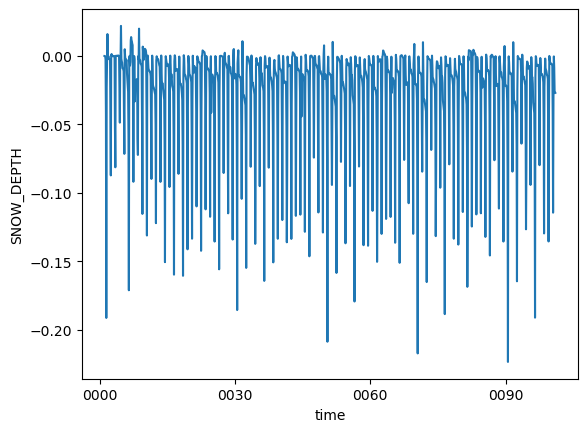

In [27]:
(ds.SNOW_DEPTH.isel(sim=3)- ds.SNOW_DEPTH.isel(sim=2)).plot()